# **Использование модели SAM для сегментации объектов (мяч, персона) с помощью рамок и точек.**


# **Часть 1**

In [ ]:
!pip install -q supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
import os
import sys
import cv2
import supervision as sv
import random
import torch
import shutil
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
HOME = os.getcwd()

%cd {HOME}
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir {HOME}/weights
%cd {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
%cd {HOME}

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ck_18py1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ck_18py1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=8b65bb33d8257c5c96662293da59fb52f6f0d38fdb79a1374c1d0e3d09a79736
  Stored in directory: /tmp/pip-ephem-wheel-cache-nt2rzaqk/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
/content/weights
/content


Функции и классы

In [ ]:
def segment_SAM(image_path, mask_generator, predictor, dots=None, dots_labels=None, bbox:np.array=None, bboxes:torch.tensor=None, random_color=False):


    def show_anns(anns):
        if len(anns) == 0:
            return
        sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
        ax = plt.gca()
        ax.set_autoscale_on(False)
        ax.axis('off')

        img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
        img[:,:,3] = 0
        for ann in sorted_anns:
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = color_mask
        ax.imshow(img)
        plt.show()

    def show_mask(mask, ax, random_color=False):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    def show_dots(coords, labels, ax, marker_size=100):
        pos_points = coords[labels==1]
        neg_points = coords[labels==0]
        ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)
        ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=marker_size, edgecolor='white', linewidth=1.25)

    def show_bbox(bbox, ax):
        x0, y0 = bbox[0], bbox[1]
        w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=3))

    def display_results(image):
        plt.figure(figsize=(16, 16))
        source_img_ax, segmented_img_ax = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)

        source_img_ax.set_title('Исходное изображение')
        source_img_ax.axis('off')
        source_img_ax.imshow(image)

        segmented_img_ax.set_title('Сегментированное изображение')
        segmented_img_ax.axis('off')
        segmented_img_ax.imshow(image)


    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    if dots is None and bbox is None and bboxes is None:
        sam_result = mask_generator.generate(image_rgb)
        display_results(image_rgb)
        show_anns(sam_result)

    if dots is not None or bbox is not None:
        predictor.set_image(image_rgb)
        masks, _, _ = predictor.predict(
        point_coords=dots,
        point_labels=dots_labels,
        box=bbox,
        multimask_output=False,
        )
        display_results(image_rgb)
        for mask in masks:
            show_mask(masks, plt.gca(), random_color=random_color)
        if dots is not None:
            show_dots(dots, dots_labels, plt.gca())
        if bbox is not None:
            show_bbox(bbox, plt.gca())
        return

    if bboxes is not None:
        predictor.set_image(image_rgb)
        transformed_bboxes = predictor.transform.apply_boxes_torch(bboxes, image_rgb.shape[:2])
        masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_bboxes,
        multimask_output=False)
        display_results(image_rgb)
        for mask in masks:
            show_mask(mask.cpu().numpy(), plt.gca(), random_color=random_color)
        for bbox in bboxes:
            show_bbox(bbox.cpu().numpy(), plt.gca())

# В этом коде реализована функция segment_SAM, которая выполняет сегментацию изображений с использованием модели SAM (Segment Anything Model). Функция принимает на вход путь к изображению,
# генератор маски, предиктор, координаты точек, метки точек, ограничивающие рамки и флаг случайного цвета.
# В зависимости от переданных параметров, функция может выполнять различные задачи. Если не указаны точки и ограничивающие рамки, функция генерирует сегментацию для всего изображения.
# Если указаны точки или ограничивающая рамка, функция выполняет предсказание для этих областей. Если указаны несколько ограничивающих рамок, функция выполняет предсказание для каждой из них.
# Результаты сегментации отображаются на изображении с помощью вспомогательных функций, таких как show_anns, show_mask, show_dots и show_bbox.
# Эти функции отображают аннотации, маски, точки и ограничивающие рамки соответственно.
# В целом, этот код решает задачу сегментации изображений с использованием модели SAM, позволяя визуализировать результаты сегментации.

Параметры и переменные

In [ ]:
person_with_the_ball_image_path = '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-03-47.png'
person_and_the_ball_image_path = '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-05-24.png'
person_ball_image_path = '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-06-08.png'
yellow_ball_image_path = '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-06-50.png'
the_ball_image_path = '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-09-19.png'
person_and_ball_image_path = '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-10-26.png'
person_and_yellow_ball_image_path = '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-11-54.png'
volleyball_player_ball_image_path = '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-12-37.png'
athlet_with_the_yellow_valleyball_ball_image_path  = '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-04-30_03-00-02.png'
athlet_and_the_yellow_ball_image_path  = '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-20_23-44-13.png'

Сегментация всех элементов на изображении с помощью SAM

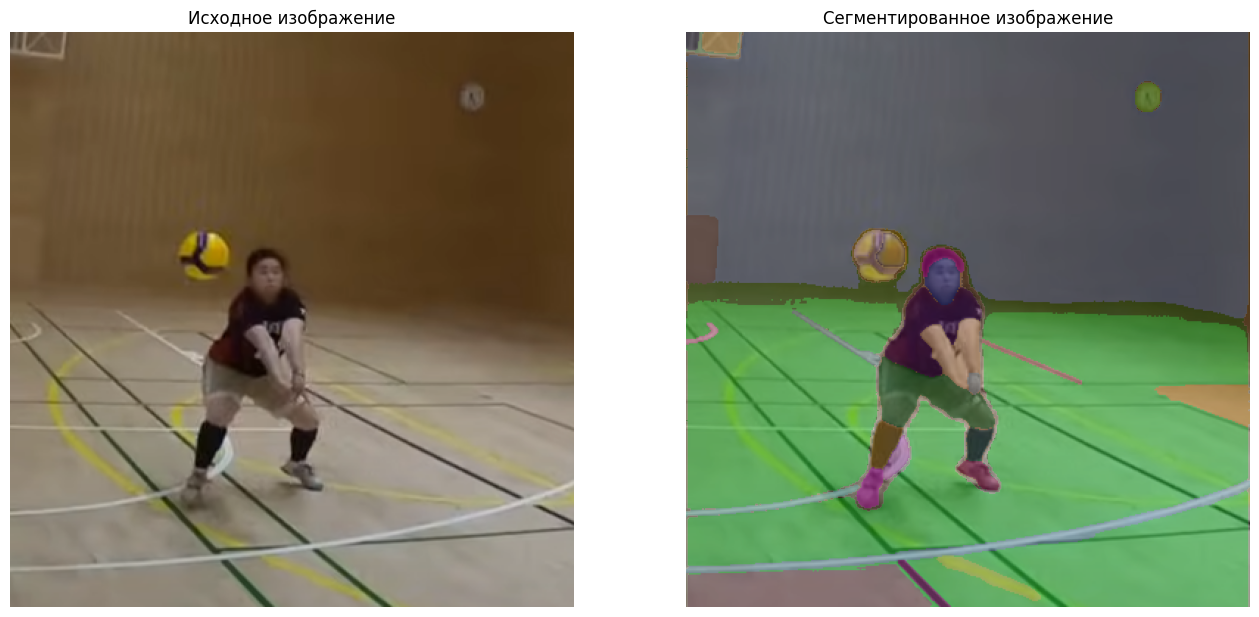

In [ ]:
segment_SAM(person_with_the_ball_image_path, mask_generator, predictor)

Сегментация отдельных объектов на изображении указанием их ограничивающими рамками подаваемыми в SAM вместе с изображением

В этом коде используется display для отображения изображения и clear_output для очистки вывода перед обновлением изображения с новыми координатами bbox. Функция plt.waitforbuttonpress() используется для ожидания завершения выбора bbox перед закрытием изображения.

 # Создание фигуры и осей

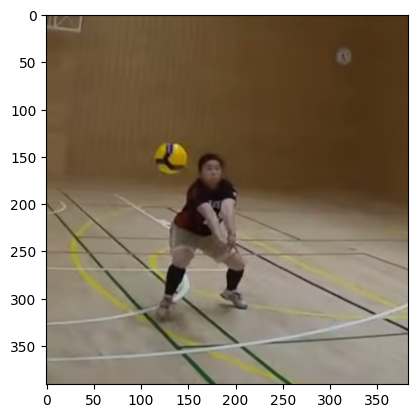

BBox for /content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-03-47.png: []


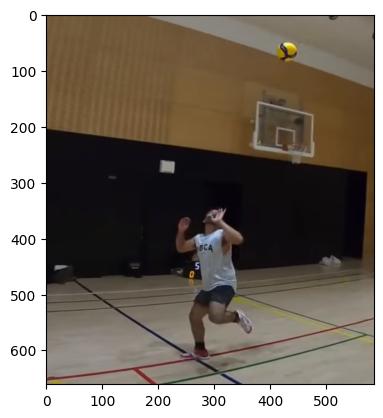

BBox for /content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-05-24.png: []


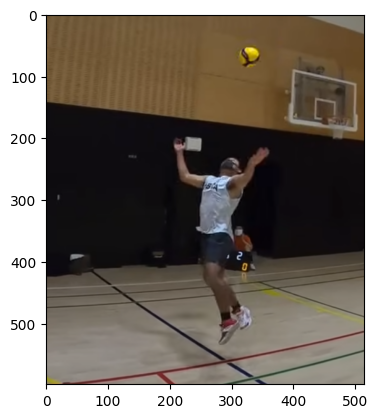

BBox for /content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-06-08.png: []


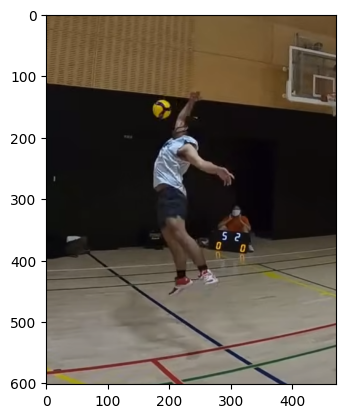

BBox for /content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-06-50.png: []


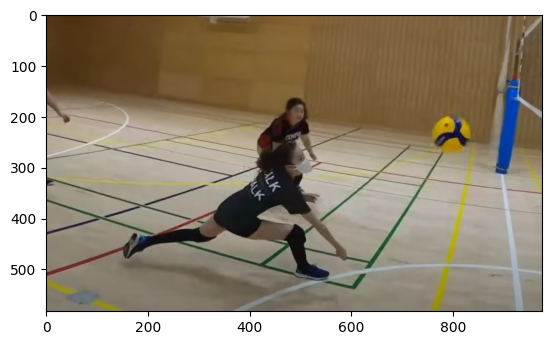

BBox for /content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-09-19.png: []


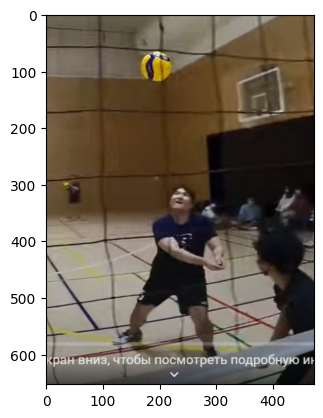

BBox for /content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-10-26.png: []


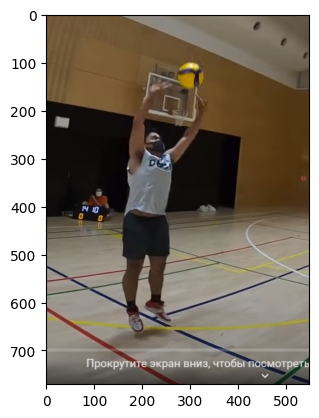

BBox for /content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-11-54.png: []


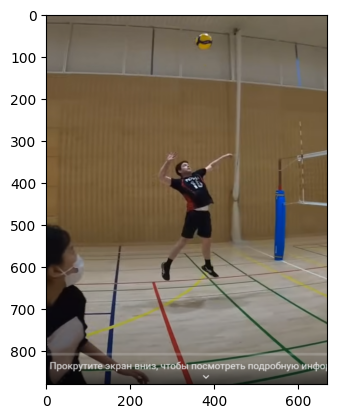

BBox for /content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-12-37.png: []


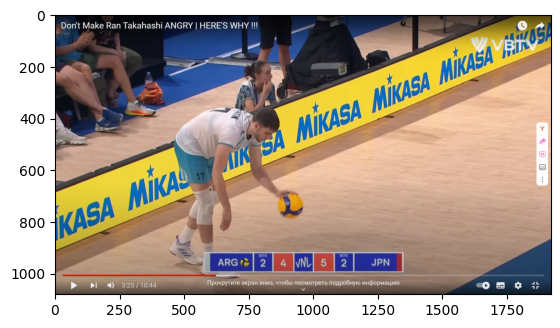

BBox for /content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-04-30_03-00-02.png: []


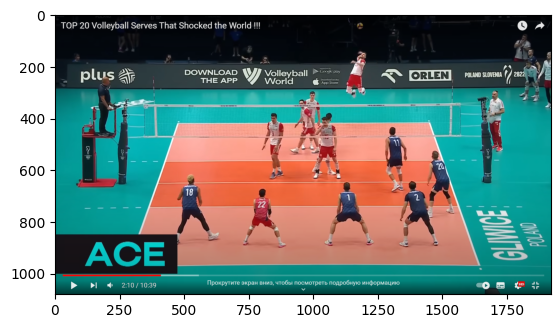

BBox for /content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-20_23-44-13.png: []


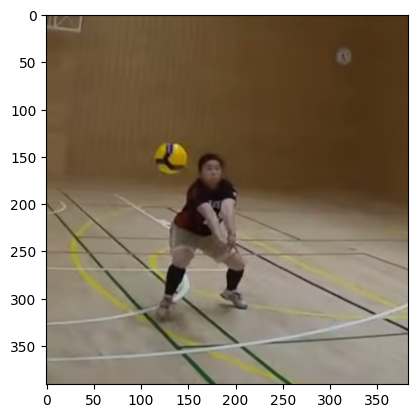

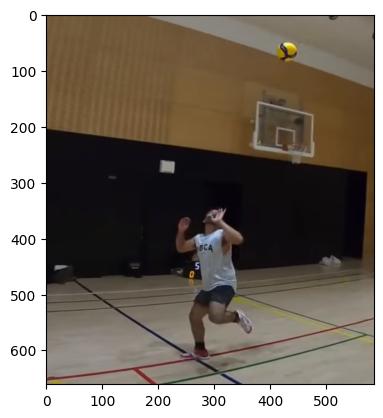

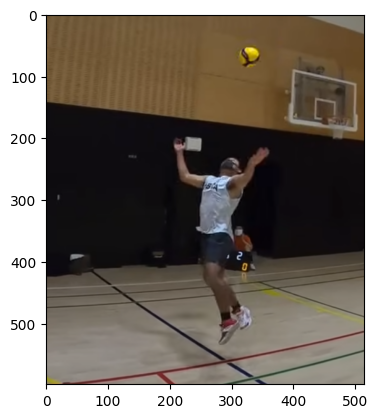

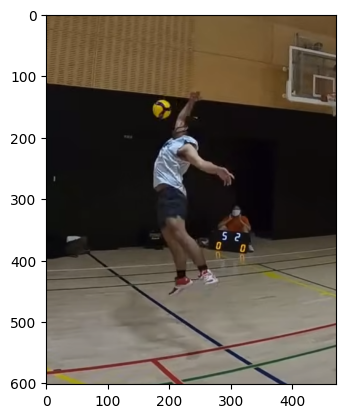

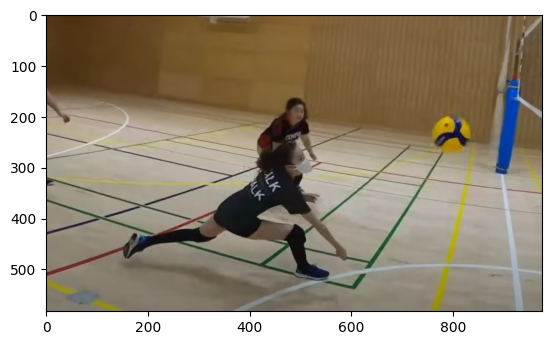

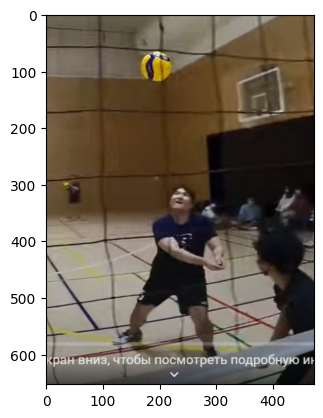

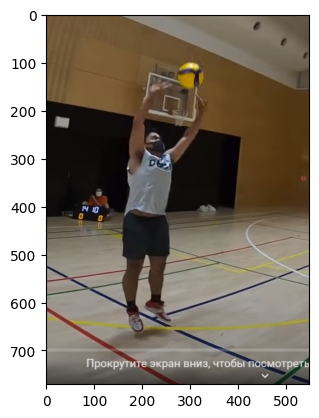

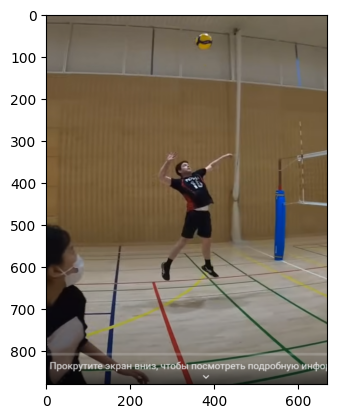

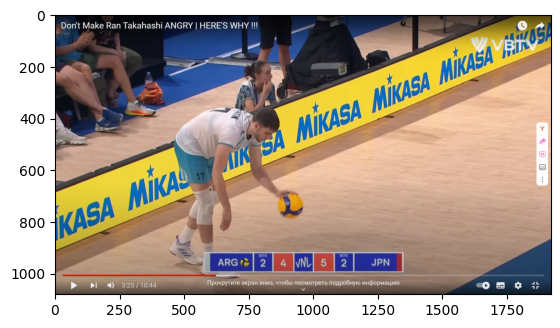

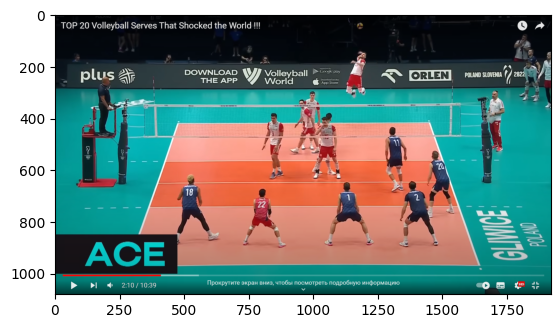

In [ ]:
 # "Создание фигуры и осей"

# В этом коде реализован процесс выбора ограничивающих рамок (bbox) для изображений. Сначала загружается список путей к изображениям, хранящимся на Google Диске.
# Затем определяется функция select_bbox, которая загружает и отображает изображение, а затем позволяет пользователю выбрать ограничивающую рамку, отслеживая координаты мыши при клике.
# После выбора рамки, координаты преобразуются в массив numpy и возвращаются функцией. Этот процесс повторяется для каждого изображения в списке.
# В результате, для каждого изображения выводится его ограничивающая рамка. Это может быть полезно для задач обработки изображений, таких как сегментация объектов,
# где необходимо указать конкретную область изображения для анализа.

from IPython.display import display, clear_output

# Список путей к изображениям
image_paths = [
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-03-47.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-05-24.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-06-08.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-06-50.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-09-19.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-10-26.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-11-54.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-12-37.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-04-30_03-00-02.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-20_23-44-13.png'
]

# Функция для отображения изображения и выбора bbox
def select_bbox(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Создание фигуры и осей
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Функция для отслеживания координат мыши
    coords = []
    def onclick(event):
        # Здесь используем nonlocal вместо global, так как coords определен внутри функции
        nonlocal coords
        coords.append((event.xdata, event.ydata))
        # Отображение текущего выбора координат
        clear_output(wait=True)
        display(fig)

    # Связывание функции с событием
    # cid = fig.canvas.mpl_connect('button_press_event', onclick)

    display(fig)

    # Ожидание завершения выбора bbox
    # plt.waitforbuttonpress()
    # plt.close(fig)

    # Преобразование координат в bbox
    return np.array(coords).astype(int)

# Цикл для обработки каждого изображения
for image_path in image_paths:
    bbox = select_bbox(image_path)
    print(f'BBox for {image_path}: {bbox}')

Координаты точек заданы с помощью сервиса VGG Image Annotator. Ббоксы мячей.

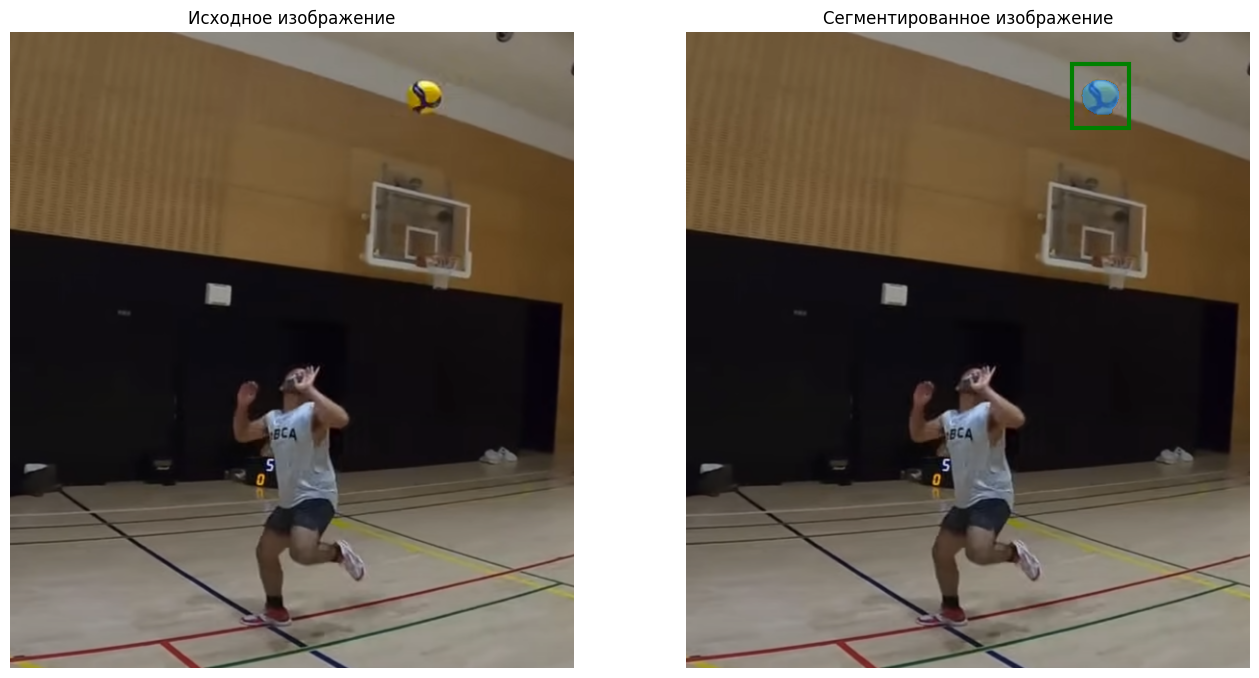

In [ ]:
# Наложение маски сегментации на нужный объект на изображении путем указания объекта ограничивающей рамкой

bbox = np.array([400, 33, 460, 99])
segment_SAM(person_and_the_ball_image_path, mask_generator, predictor, bbox=bbox)

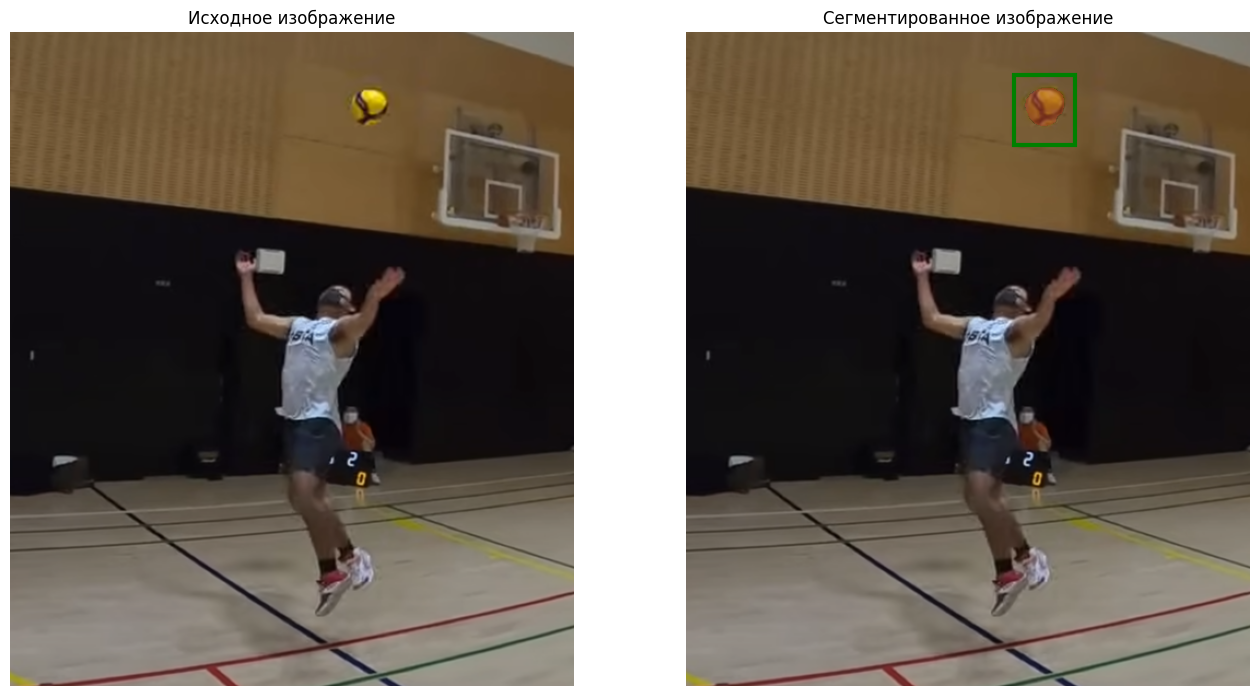

In [ ]:
# Наложение маски сегментации на нужный объект на изображении путем указания объекта ограничивающей рамкой

bboxes = torch.tensor([[299, 39, 355, 103]], device=predictor.device)
masks = segment_SAM(person_ball_image_path, mask_generator, predictor, bboxes=bboxes, random_color=True)

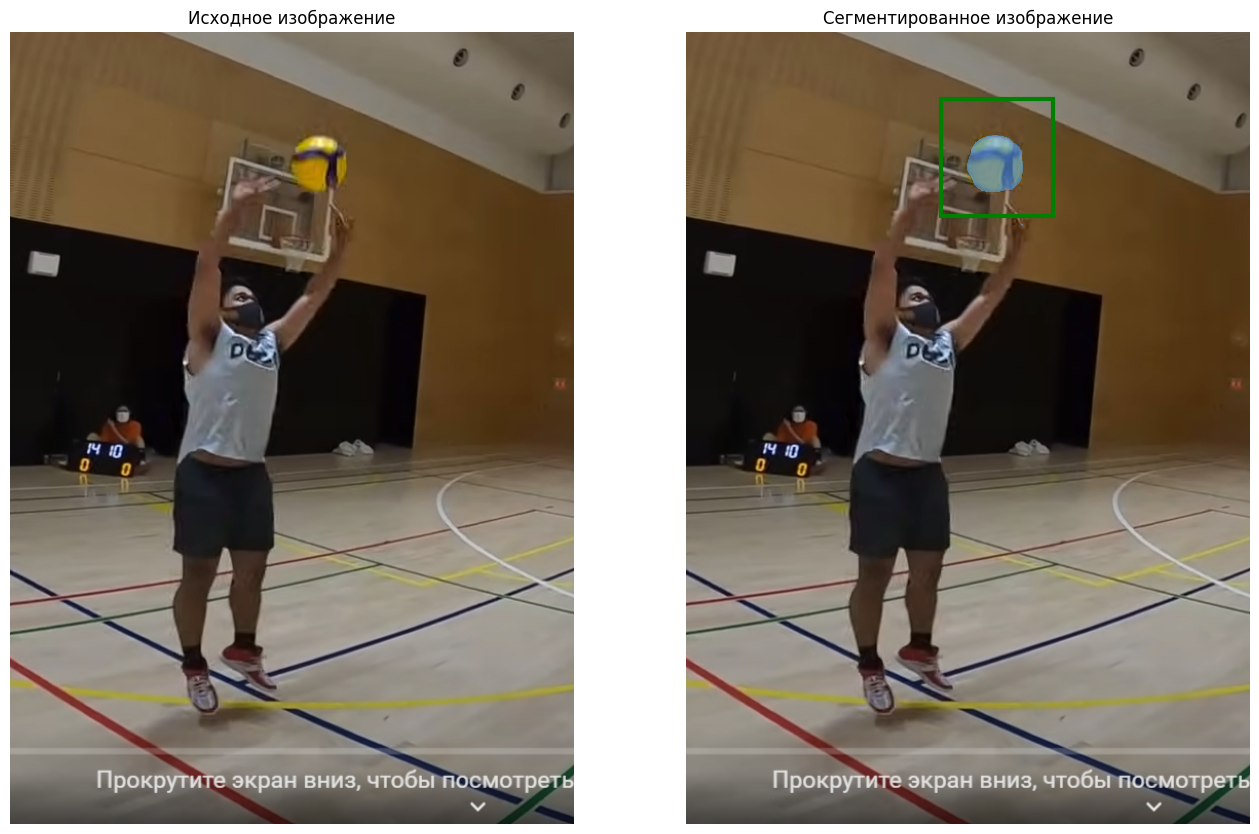

In [ ]:
# Наложение маски сегментации на нужный объект на изображении путем указания объекта ограничивающей рамкой

bboxes = torch.tensor([[248, 64, 357, 178]], device=predictor.device)
masks = segment_SAM(person_and_yellow_ball_image_path, mask_generator, predictor, bboxes=bboxes, random_color=True)

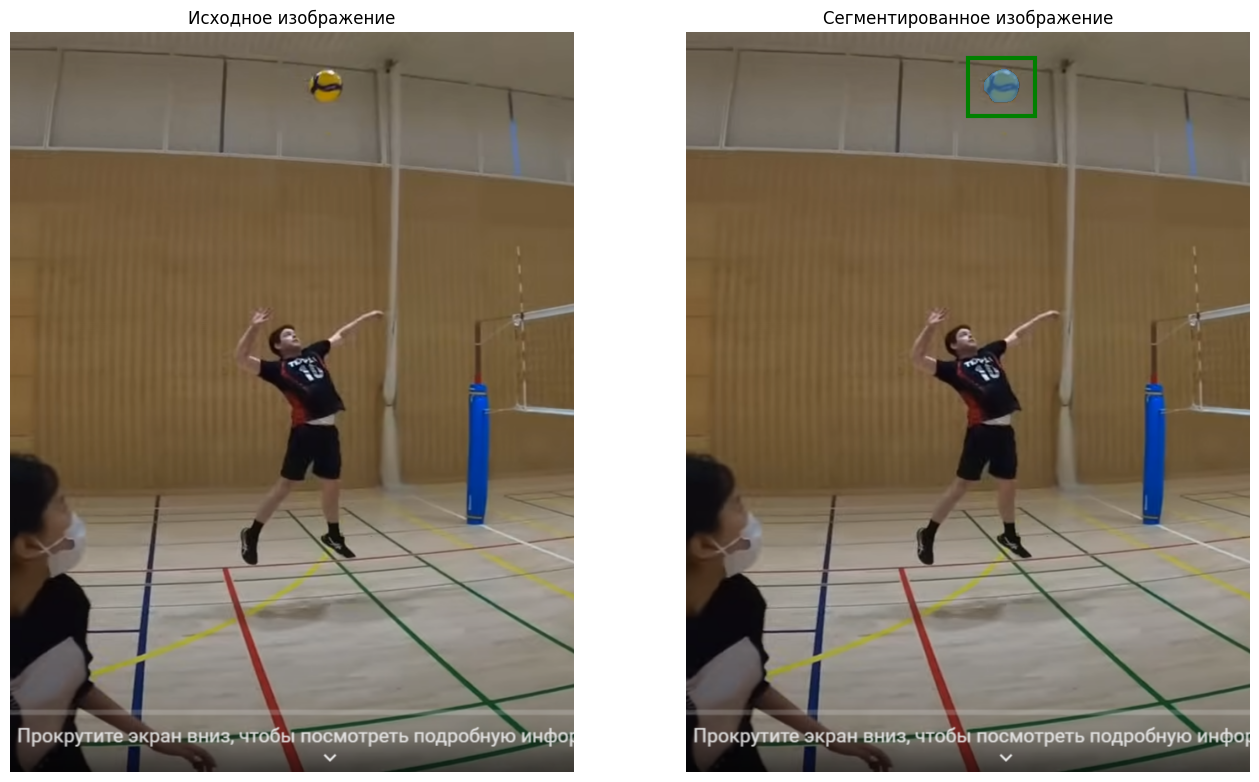

In [ ]:
# Наложение маски сегментации на нужный объект на изображении путем указания объекта ограничивающей рамкой

bboxes = torch.tensor([[334, 31, 414, 100]], device=predictor.device)
masks = segment_SAM(volleyball_player_ball_image_path, mask_generator, predictor, bboxes=bboxes, random_color=True)

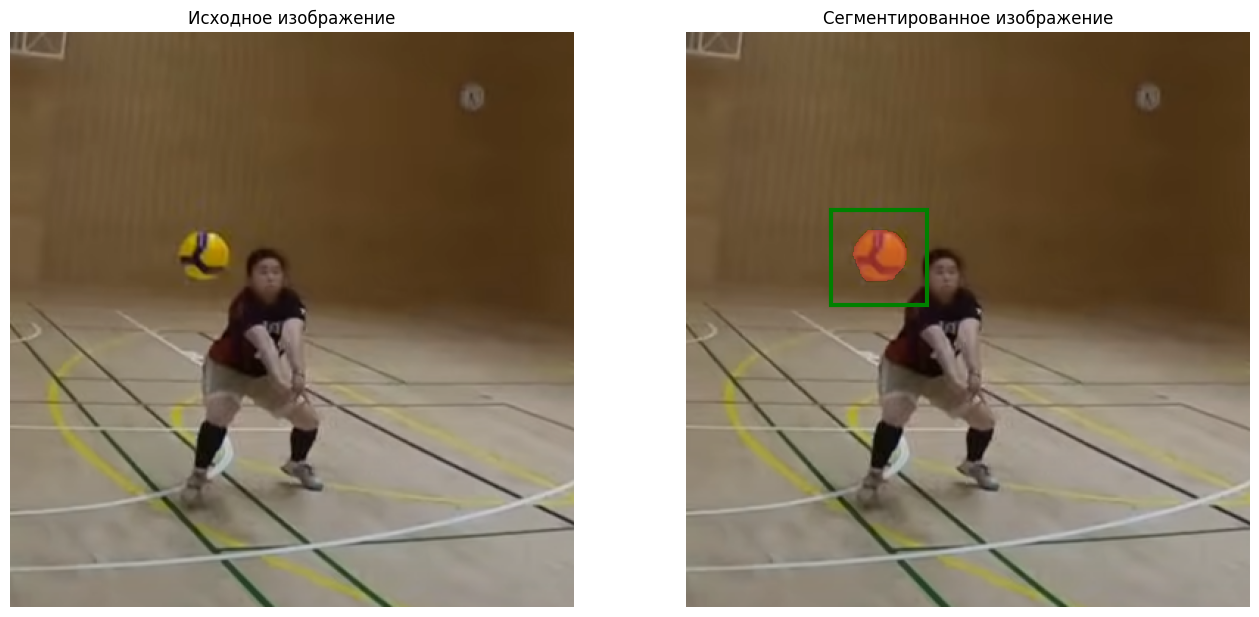

In [ ]:
# Наложение маски сегментации на нужный объект на изображении путем указания объекта ограничивающей рамкой

bboxes = torch.tensor([[98, 121, 163, 185]], device=predictor.device)
masks = segment_SAM(person_with_the_ball_image_path, mask_generator, predictor, bboxes=bboxes, random_color=True)

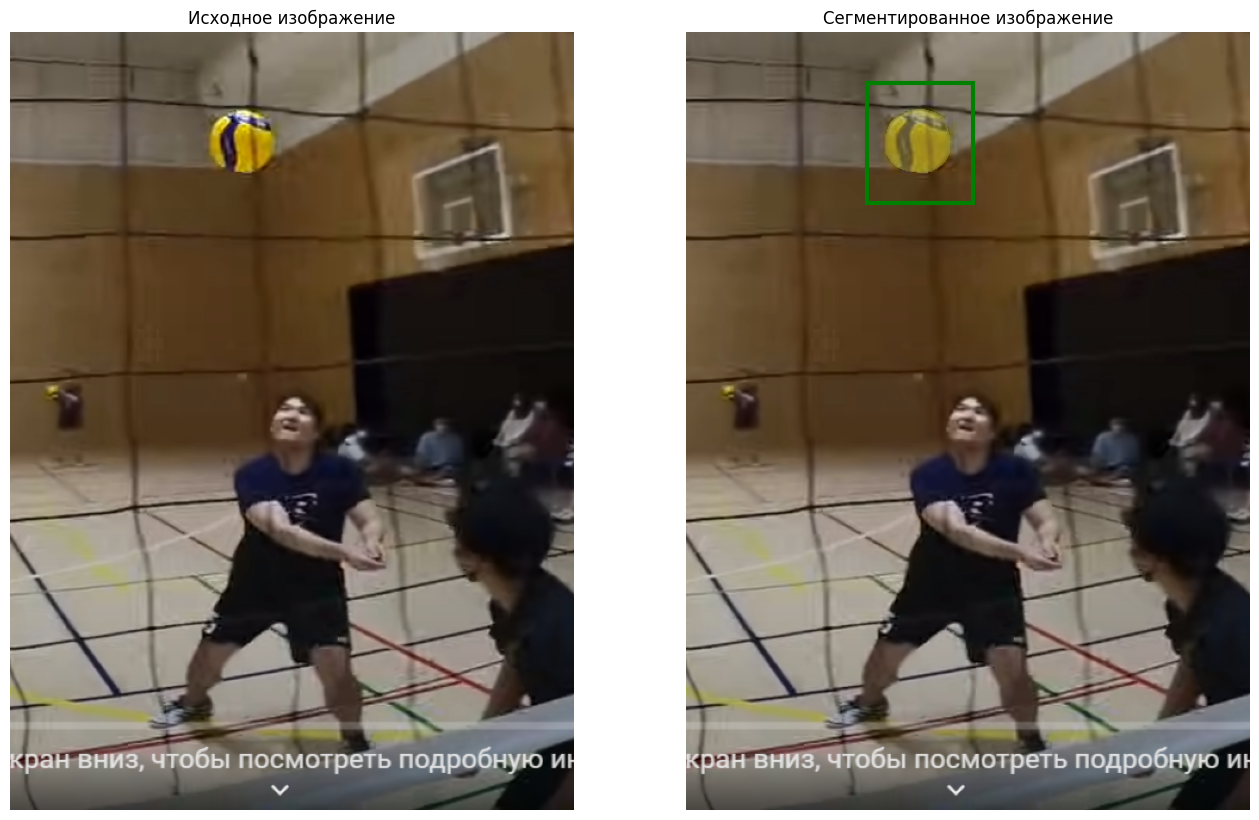

In [ ]:
# Наложение маски сегментации на нужный объект на изображении путем указания объекта ограничивающей рамкой

bboxes = torch.tensor([[151, 42, 240, 143]], device=predictor.device)
masks = segment_SAM(person_and_ball_image_path, mask_generator, predictor, bboxes=bboxes, random_color=True)

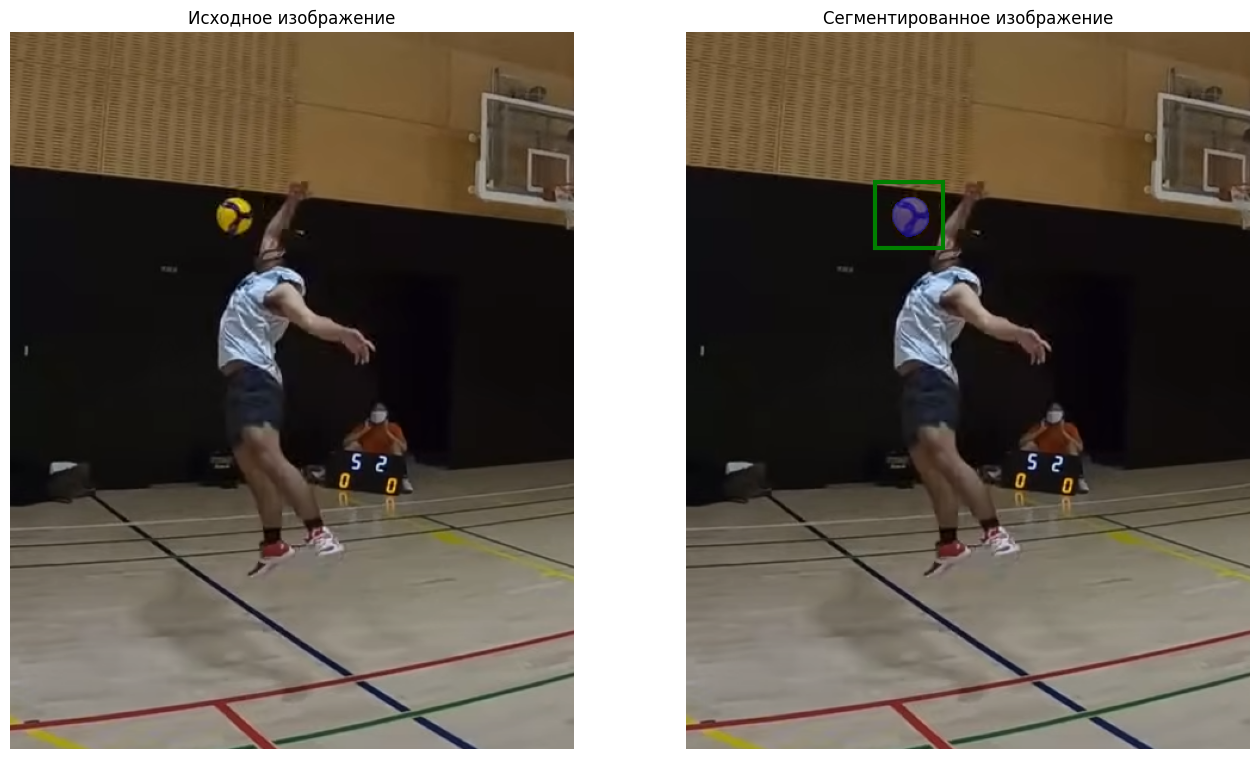

In [ ]:
# Наложение маски сегментации на нужный объект на изображении путем указания объекта ограничивающей рамкой

bboxes = torch.tensor([[158, 126, 215, 181]], device=predictor.device)
masks = segment_SAM(yellow_ball_image_path, mask_generator, predictor, bboxes=bboxes, random_color=True)

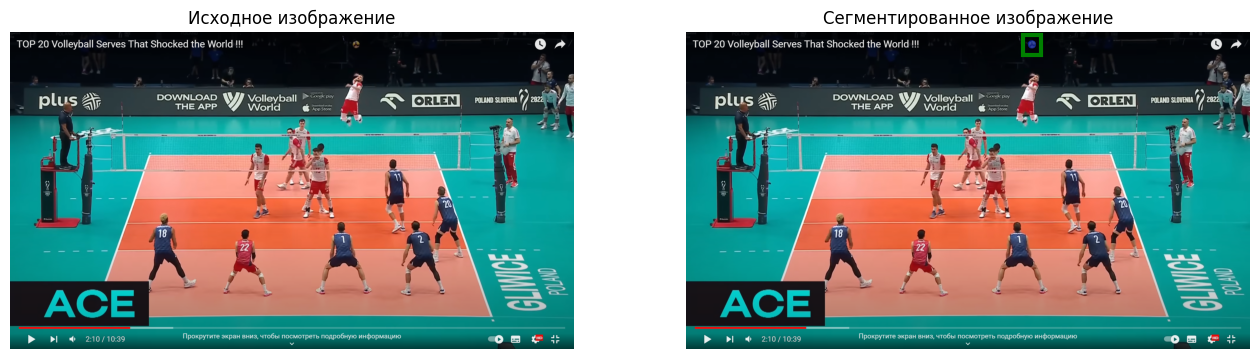

In [ ]:
# Наложение маски сегментации на нужный объект на изображении путем указания объекта ограничивающей рамкой

bboxes = torch.tensor([[1147, 9, 1209, 79]], device=predictor.device)
masks = segment_SAM(athlet_and_the_yellow_ball_image_path, mask_generator, predictor, bboxes=bboxes, random_color=True)

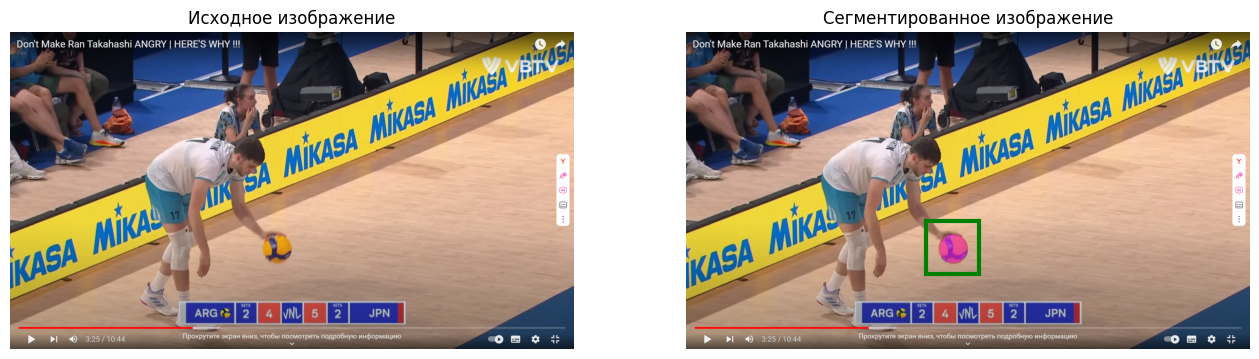

In [ ]:
# Наложение маски сегментации на нужный объект на изображении путем указания объекта ограничивающей рамкой

bboxes = torch.tensor([[816, 645, 995, 824]], device=predictor.device)
masks = segment_SAM(athlet_with_the_yellow_valleyball_ball_image_path, mask_generator, predictor, bboxes=bboxes, random_color=True)

Выделение на изображении сложных объектов созданием маски с помощью положительных точек

Выделение семантически односложного объекта

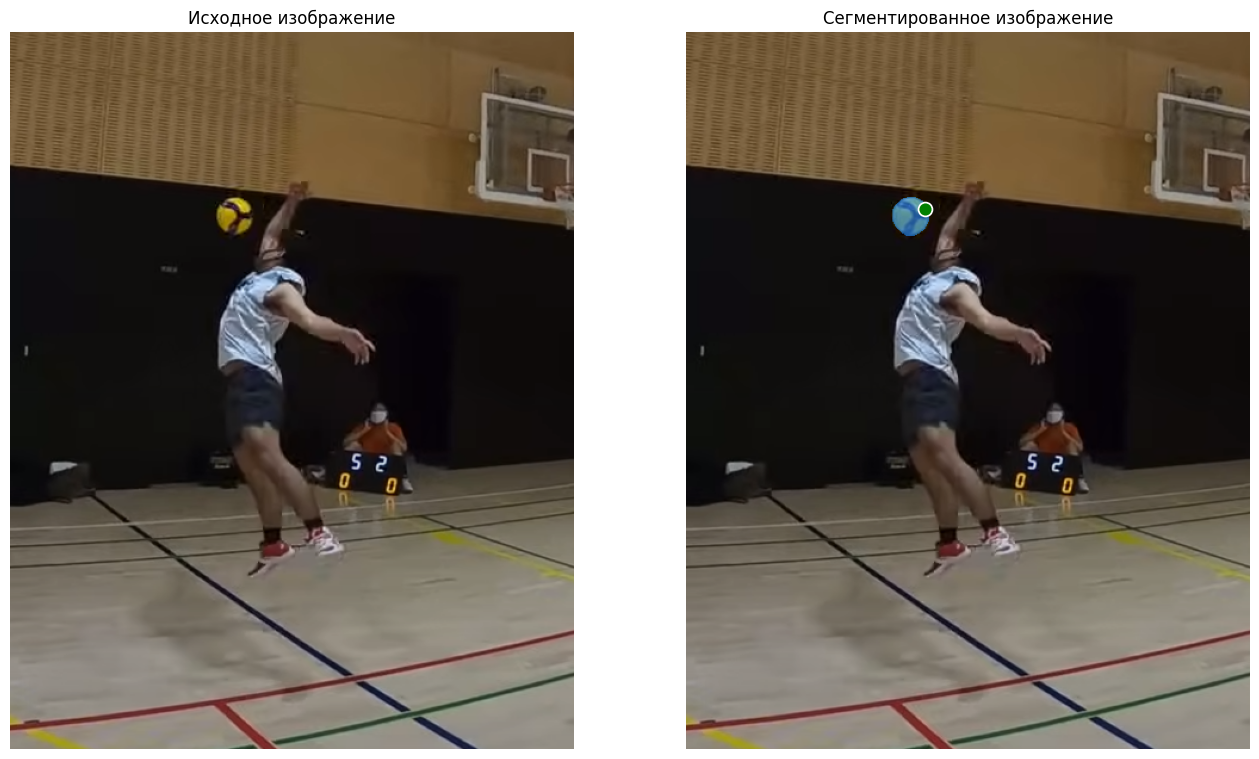

In [ ]:
# Выделение объекта с помощью одной положительной точки

dots = np.array([[200, 148]])
dots_labels = np.array([1])
segment_SAM(yellow_ball_image_path, mask_generator, predictor, dots=dots, dots_labels=dots_labels)

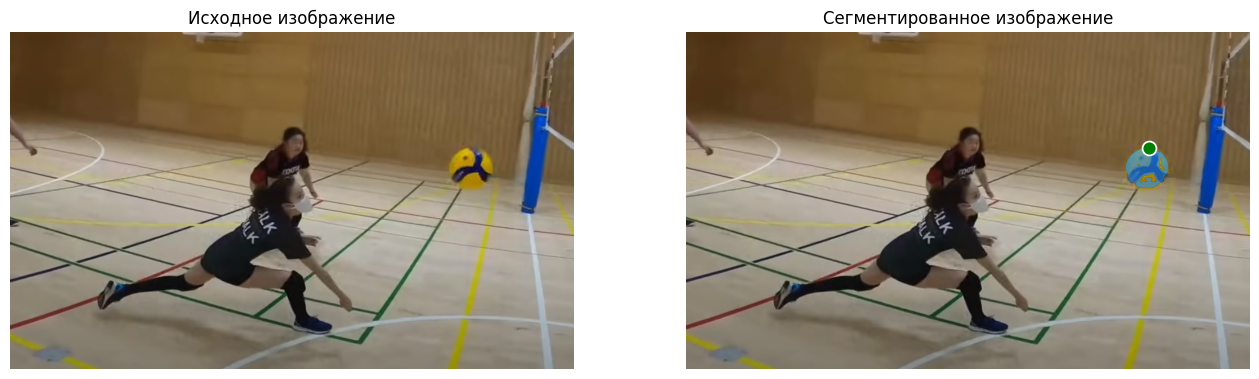

In [ ]:
# Выделение объекта с помощью одной положительной точки

dots = np.array([[800, 200]])
dots_labels = np.array([1])
segment_SAM(the_ball_image_path, mask_generator, predictor, dots=dots, dots_labels=dots_labels)

Выделение составного объекта с помощью массива положительных и отрицательных точек

Пример ошибки

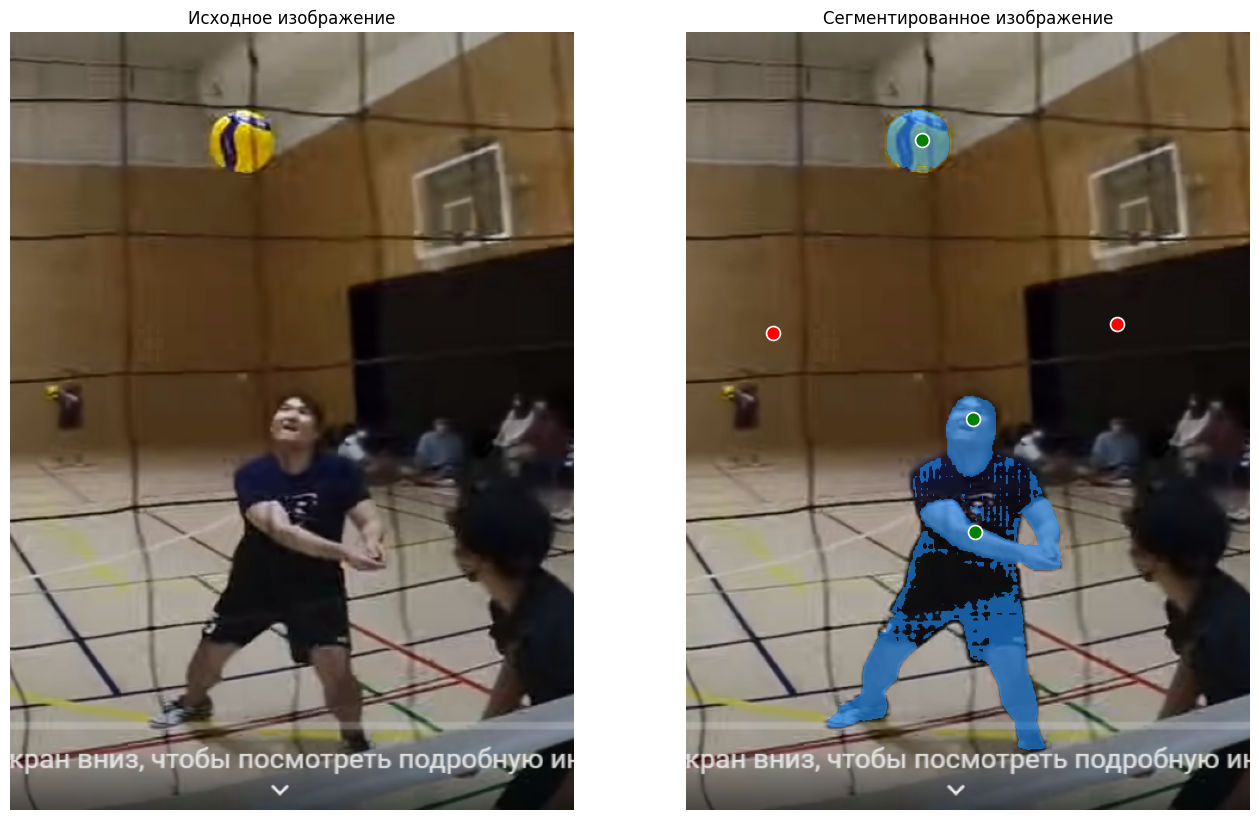

In [ ]:
# добавим еще 2 положительные точки и 2 отрицательных

dots = np.array([[197, 90], [240, 324], [242, 419], [72, 252], [361, 245]])
dots_labels = np.array([1, 1, 1, 0, 0])
segment_SAM(person_and_ball_image_path, mask_generator, predictor, dots=dots, dots_labels=dots_labels)

# **Часть 2**

# Обучение с предобученной моделью под названием bestv9c.

In [ ]:
!pip install ultralytics

In [ ]:
!pip install dill

In [ ]:
# Вариант 1
# Загрузка модели
model_path = '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /bestv9c.pt'  # замените на путь к вашей модели
model = torch.load(model_path)
model.eval()

# Функция для предобработки изображения
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0)
    return image

# Функция для получения предсказания
def get_prediction(image_tensor):
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        return predicted

# Пример использования
image_paths = [
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-03-47.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-05-24.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-06-08.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-06-50.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-09-19.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-10-26.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-11-54.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-12-37.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-04-30_03-00-02.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-20_23-44-13.png'
    ]
               # замените на пути к вашим изображениям
for image_path in image_paths:
    image_tensor = preprocess_image(image_path)
    prediction = get_prediction(image_tensor)
    print(f'Predicted class for {image_path}: {prediction.item()}')

AttributeError: 'dict' object has no attribute 'eval'

# **Описание ошибки:**

Copilot

Ошибка AttributeError: 'dict' object has no attribute 'eval' говорит о том, что объект, который вы пытаетесь использовать как модель PyTorch (то есть объект, который вы загрузили из файла bestv9c.pt), на самом деле является словарем (dict), а не моделью PyTorch.

Это может произойти, если файл bestv9c.pt был сохранен как словарь состояния модели (state_dict), а не как полная модель. Словарь состояния модели содержит веса и смещения каждого слоя модели, но не содержит информацию о самой архитектуре модели.

Чтобы загрузить модель из словаря состояния, вам сначала нужно создать экземпляр модели с правильной архитектурой, а затем загрузить веса в эту модель. Вот пример того, как это можно сделать:

Python

# Создание модели
model = YourModel()  # замените на вашу модель

# Загрузка весов
model_path = '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /bestv9c.pt'  # замените на путь к вашей модели
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

model.eval()
Код, созданный ИИ. Внимательно просмотрите и используйте. Дополнительные сведения о часто задаваемых вопросах.
В этом коде YourModel() должен быть заменен на класс вашей модели. Если у вас нет кода для создания вашей модели, вам нужно будет его получить. Это может быть в том же репозитории или проекте, откуда вы получили файл bestv9c.pt, или вы можете попросить его у того, кто дал вам этот файл.

Пожалуйста, учтите, что этот код является общим примером и может потребовать дополнительной настройки или изменений в зависимости от вашей конкретной ситуации и версии PyTorch. Если у вас возникнут проблемы или вопросы, не стесняйтесь задать их!

In [ ]:
# Вариант 2
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim

# Загрузка модели
model = torch.load('/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /bestv9c.pt')
model.train()  # Установка модели в режим обучения

# Класс датасета
class VolleyballDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image = self.transform(image)
        return image

# Список путей к изображениям
image_paths = ['/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-03-47.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-05-24.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-06-08.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-06-50.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-09-19.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-10-26.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-11-54.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-21_00-12-37.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-04-30_03-00-02.png',
    '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /GoPro Volleyball #34/2024-05-20_23-44-13.png'
]

# Создание датасета и даталоадера
dataset = VolleyballDataset(image_paths)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Цикл обучения
num_epochs = 5  # Количество эпох
for epoch in range(num_epochs):
    for images in dataloader:
        outputs = model(images)
        loss = criterion(outputs, torch.ones(images.size(0), dtype=torch.long))  # Предполагаем, что все изображения - волейбольные мячи
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Сохранение обученной модели
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /bestv9c_finetuned.pt')

AttributeError: 'dict' object has no attribute 'train'

In [ ]:
# Описание ошибки:

# Ошибка AttributeError: 'dict' object has no attribute 'train' указывает на то, что объект, который вы пытаетесь загрузить с помощью torch.load, является словарем (dict), а не моделью. Это может произойти, если модель была сохранена с дополнительными элементами, такими как состояние оптимизатора или другие параметры, в формате словаря.

# Чтобы решить эту проблему, вам нужно будет загрузить состояние модели из этого словаря. Вот пример того, как это можно сделать:

# Загрузка словаря, содержащего модель и возможно другие элементы
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/VOLLEYPLAY_стажировка (старички) /bestv9c.pt')

# Загрузка состояния модели
model = checkpoint['model']
model.eval()  # Перевод модели в режим оценки

# Если в словаре есть состояние оптимизатора и вы хотите продолжить обучение, загрузите его тоже
# optimizer = optim.Adam(model.parameters())
# optimizer.load_state_dict(checkpoint['optimizer'])

# Теперь можно продолжить обучение или использовать модель для предсказания


# Убедитесь, что ключ 'model' соответствует тому, как модель была сохранена в словаре. Если ключ отличается, используйте правильный ключ
# для доступа к состоянию модели. Если вы хотите продолжить обучение и в словаре сохранено состояние оптимизатора, вам также нужно будет
# загрузить это состояние перед продолжением обучения.


Вариант 1 и вариант 2 оба используют модель глубокого обучения для работы с изображениями, но они решают разные задачи.

Вариант 1 загружает предварительно обученную модель и использует ее для классификации изображений. Для каждого изображения выполняется предобработка, включающая изменение размера, центральную обрезку, преобразование в тензор и нормализацию. Затем модель делает предсказание для каждого изображения. Этот вариант используется для предсказания классов для заданных изображений.

Вариант 2 также загружает модель, но затем переводит ее в режим обучения и использует для дальнейшего обучения на новых данных. Создается специальный класс датасета для чтения и предобработки изображений. Затем создается даталоадер для загрузки данных батчами. Затем выполняется цикл обучения, в котором модель делает предсказания для батча изображений, вычисляется функция потерь, выполняется обратное распространение ошибки и обновляются веса модели. Этот процесс повторяется на протяжении нескольких эпох. Этот вариант используется для дообучения модели на новых данных.

   В результате ошибок продвинуться дальше не удалось.

# **Резюме:**  
в данной работе используется модель SAM (Segment Anything Model) для сегментации изображений. Модель загружается и используется для генерации масок сегментации для различных объектов на изображениях.

В одном из вариантов использования модели SAM применяется ко всему изображению без указания конкретных областей или объектов. В других вариантах использования задаются ограничивающие рамки (bbox) или точки, которые указывают на объекты, подлежащие сегментации.

В случае использования bbox, маска сегментации налагается на объект внутри bbox. Если заданы точки, то маска сегментации создается с использованием положительных точек.

Результаты сегментации отображаются на изображении, позволяя визуально оценить результаты работы модели. Это может быть полезно для анализа изображений, где необходимо выделить определенные объекты, например, для дальнейшего анализа или обработки.

В целом, модель SAM демонстрирует эффективность в задачах сегментации изображений.